In [1]:
from dsc80_utils import *

In [2]:
# Pandas Tutor setup
%reload_ext pandas_tutor
%set_pandas_tutor_options {"maxDisplayCols": 8, "nohover": True, "projectorMode": True}
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Lecture 5 – Exploratory Data Analysis and Data Cleaning

## DSC 80, Fall 2024

### Announcements 📣

- Lab 2 due tomorrow, **Wed, April 17**.
- Project 1 is due this **Fri, April 19**.

### Agenda 📆

- Dataset overview.
- Introduction to `plotly`.
- Exploratory data analysis and feature types.
- Data cleaning.
    - Data quality checks.
    - Missing values.
    - Transformations and timestamps.
    - Modifying structure.
- Investigating student-submitted questions!

## Merging

### Example: Name categories

The [New York Times article from Lecture 1](https://archive.is/NpORG) claims that certain categories of names are becoming more popular. For example:

- Forbidden names like Lucifer, Lilith, Kali, and Danger.

- Evangelical names like Amen, Savior, Canaan, and Creed.

- Mythological names.

- It also claims that baby boomer names are becoming less popular.

Let's see if we can verify these claims using data!

### Loading in the data

Our first DataFrame, `baby`, is the same as we saw in Lecture 1. It has one row for every combination of `'Name'`, `'Sex'`, and `'Year'`.

In [3]:
baby_path = Path('data') / 'baby.csv'
baby = pd.read_csv(baby_path)
baby

,Name,Sex,Count,Year
0,Liam,M,20456,2022
1,Noah,M,18621,2022
2,Olivia,F,16573,2022
...,...,...,...,...
2085155,Wright,M,5,1880
2085156,York,M,5,1880
2085157,Zachariah,M,5,1880


Our second DataFrame, `nyt`, contains the New York Times' categorization of each of several names, based on the aforementioned article.

In [4]:
nyt_path = Path('data') / 'nyt_names.csv'
nyt = pd.read_csv(nyt_path)
nyt

,nyt_name,category
0,Lucifer,forbidden
1,Lilith,forbidden
2,Danger,forbidden
...,...,...
20,Venus,celestial
21,Celestia,celestial
22,Skye,celestial


**Issue**: To find the number of babies born with (for example) forbidden names each year, we need to combine information from both `baby` and `nyt`.

### Merging

- We want to link rows from `baby` and `nyt` together whenever the names match up.
- This is a **merge** (`pandas` term), i.e. a **join** (SQL term).
- A merge is appropriate when we have two sources of information **about the same individuals** that is **linked by a common column(s)**.
- The common column(s) are called the **join key**.

### Example merge

Let's demonstrate on a small subset of `baby` and `nyt`.

In [5]:
nyt_small = nyt.iloc[[11, 12, 14]].reset_index(drop=True)

names_to_keep = ['Julius', 'Karen', 'Noah']
baby_small = (baby
 .query("Year == 2020 and Name in @names_to_keep")
 .reset_index(drop=True)
)

dfs_side_by_side(baby_small, nyt_small)

In [76]:
%%pt
baby_small.merge(nyt_small, left_on='Name', right_on='nyt_name')

### The `merge` method

- The `merge` DataFrame method joins two DataFrames by columns or indexes.
    - As mentioned before, "merge" is just the `pandas` word for "join."

- When using the `merge` method, the DataFrame before `merge` is the "left" DataFrame, and the DataFrame passed into `merge` is the "right" DataFrame.
    - In `baby_small.merge(nyt_small)`, `baby_small` is considered the "left" DataFrame and `nyt_small` is the "right" DataFrame; the columns from the left DataFrame appear to the left of the columns from right DataFrame.

- By default:
    - If join keys are not specified, all shared columns between the two DataFrames are used.
    - The "type" of join performed is an inner join. **This is the only type of join you saw in DSC 10, but there are more, as we'll now see!**

### Join types: inner joins

In [77]:
%%pt
baby_small.merge(nyt_small, left_on='Name', right_on='nyt_name')

- Note that `'Noah'` and `'Freya'` do not appear in the merged DataFrame.
- This is because there is:
    - no `'Noah'` in the right DataFrame (`nyt_small`), and
    - no `'Freya'` in the left DataFrame (`baby_small`).
- The default type of join that `merge` performs is an **inner join**, which keeps the **intersection** of the join keys.


<center><img src='imgs/image_0.png' width=20%></center>

### Different join types

We can change the type of join performed by changing the `how` argument in `merge`. Let's experiment!

In [78]:
%%pt
# Note the NaNs!
baby_small.merge(nyt_small, left_on='Name', right_on='nyt_name', how='left')

In [79]:
%%pt
baby_small.merge(nyt_small, left_on='Name', right_on='nyt_name', how='right')

In [80]:
%%pt
baby_small.merge(nyt_small, left_on='Name', right_on='nyt_name', how='outer')

### Different join types handle mismatches differently

There are four types of joins.

* **Inner**: keep **only** matching keys (intersection).
* **Outer**: keep **all** keys in both DataFrames (union).
* **Left**: keep all keys in the left DataFrame, whether or not they are in the right DataFrame.
* **Right**: keep all keys in the right DataFrame, whether or not they are in the left DataFrame.
    * Note that `a.merge(b, how='left')` contains the same information as `b.merge(a, how='right')`, just in a different order.

<center><img src='imgs/image_1.png' width=30%></center>

### Notes on the `merge` method

- `merge` is flexible – you can merge using a combination of columns, or the index of the DataFrame.
-  If the two DataFrames have the same column names, `pandas` will add `_x` and `_y` to the duplicated column names to avoid having columns with the same name (change these the `suffixes` argument).
- There is, in fact, a `join` method, but it's actually a wrapper around `merge` with fewer options.
- **As always, the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) is your friend!**

### Lots of `pandas` operations do an implicit outer join!

- `pandas` will almost always try to match up index values using an outer join.
- It won't tell you that it's doing an outer join, it'll just throw `NaN`s in your result!

In [81]:
df1 = pd.DataFrame({'a': [1, 2, 3]}, index=['hello', 'dsc80', 'students'])
df2 = pd.DataFrame({'b': [10, 20, 30]}, index=['dsc80', 'is', 'awesome'])
dfs_side_by_side(df1, df2)

,a
hello,1
dsc80,2
students,3
,b
dsc80,10
is,20
awesome,30


In [82]:
df1['a'] + df2['b']

awesome      NaN
dsc80       12.0
hello        NaN
is           NaN
students     NaN
dtype: float64

## Many-to-one & many-to-many joins

### One-to-one joins

- So far in this lecture, the joins we have worked with are called **one-to-one** joins.
- Neither the left DataFrame (`baby_small`) nor the right DataFrame (`nyt_small`) contained any duplicates in the join key.
- What if there are duplicated join keys, in one or both of the DataFrames we are merging?

In [83]:
# Run this cell to set up the next example.
profs = pd.DataFrame(
[['Sam', 'UCB', 5],
 ['Sam', 'UCSD', 5],
 ['Janine', 'UCSD', 8],
 ['Marina', 'UIC', 7],
 ['Justin', 'OSU', 5],
 ['Soohyun', 'UCSD', 2],
 ['Suraj', 'UCB', 2]],
    columns=['Name', 'School', 'Years']
)

schools = pd.DataFrame({
    'Abr': ['UCSD', 'UCLA', 'UCB', 'UIC'],
    'Full': ['University of California San Diego', 'University of California, Los Angeles', 'University of California, Berkeley', 'University of Illinois Chicago']
})

programs = pd.DataFrame({
    'uni': ['UCSD', 'UCSD', 'UCSD', 'UCB', 'OSU', 'OSU'],
    'dept': ['Math', 'HDSI', 'COGS', 'CS', 'Math', 'CS'],
    'grad_students': [205, 54, 281, 439, 304, 193]
})

### Many-to-one joins

- Many-to-one joins are joins where **one** of the DataFrames contains duplicate values in the join key. 
- The resulting DataFrame will preserve those duplicate entries as appropriate. 

In [84]:
dfs_side_by_side(profs, schools)

Note that when merging `profs` and `schools`, the information from `schools` is duplicated.
- `'University of California, San Diego'` appears three times.
- `'University of California, Berkeley'` appears twice.

In [85]:
%%pt
profs.merge(schools, left_on='School', right_on='Abr', how='left')

### Many-to-many joins

Many-to-many joins are joins where both DataFrames have duplicate values in the join key.

In [86]:
dfs_side_by_side(profs, programs)

,Name,School,Years
0,Sam,UCB,5
1,Sam,UCSD,5
2,Janine,UCSD,8
3,Marina,UIC,7
4,Justin,OSU,5
5,Soohyun,UCSD,2
6,Suraj,UCB,2
,uni,dept,grad_students
0,UCSD,Math,205
1,UCSD,HDSI,54


Before running the following cell, try predicting the number of rows in the output.

In [87]:
%%pt
profs.merge(programs, left_on='School', right_on='uni')

- `merge` stitched together every UCSD row in `profs` with every UCSD row in `programs`. 
- Since there were 3 UCSD rows in `profs` and 3 in `programs`, there are $3 \cdot 3 = 9$ UCSD rows in the output. The same applies for all other schools.

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `merge`
</div>
    
Fill in the blank so that the last statement evaluates to `True`.

```python
df = profs.merge(programs, left_on='School', right_on='uni')
df.shape[0] == (____).sum()
```

**Don't** use `merge` (or `join`) in your solution!


In [88]:
dfs_side_by_side(profs, programs)

,Name,School,Years
0,Sam,UCB,5
1,Sam,UCSD,5
2,Janine,UCSD,8
3,Marina,UIC,7
4,Justin,OSU,5
5,Soohyun,UCSD,2
6,Suraj,UCB,2
,uni,dept,grad_students
0,UCSD,Math,205
1,UCSD,HDSI,54


In [89]:
# Your code goes here.

### Returning back to our original question

Let's find the popularity of baby name categories over time. To start, we'll define a DataFrame that has one row for every combination of `'category'` and `'Year'`.

In [90]:
cate_counts = (
    baby
    .merge(nyt, left_on='Name', right_on='nyt_name')
    .groupby(['category', 'Year'])
    ['Count']
    .sum()
    .reset_index()
)
cate_counts

,category,Year,Count
0,boomer,1880,292
1,boomer,1881,298
2,boomer,1882,326
...,...,...,...
659,mythology,2020,3516
660,mythology,2021,3895
661,mythology,2022,4049


In [91]:
# We'll talk about plotting code soon!
import plotly.express as px
fig = px.line(cate_counts, x='Year', y='Count',
              facet_col='category', facet_col_wrap=3,
              facet_row_spacing=0.15,
              width=600, height=400)
fig.update_yaxes(matches=None, showticklabels=False)
fig

<div class="alert alert-info">
    <h3>Questions? 🤔</h3>
</div>

## Transforming

### Transforming values

- A **transformation** results from performing some operation on every element in a sequence, e.g. a Series.

- While we haven't discussed it yet in DSC 80, you learned how to transform Series in DSC 10, using the `apply` method. `apply` is very flexible – it takes in a function, which itself takes in a single value as input and returns a single value.

In [92]:
baby

,Name,Sex,Count,Year
0,Liam,M,20456,2022
1,Noah,M,18621,2022
2,Olivia,F,16573,2022
...,...,...,...,...
2085155,Wright,M,5,1880
2085156,York,M,5,1880
2085157,Zachariah,M,5,1880


In [93]:
def number_of_vowels(string):
    return sum(c in 'aeiou' for c in string.lower())

baby['Name'].apply(number_of_vowels)

0          2
1          2
2          4
          ..
2085155    1
2085156    1
2085157    4
Name: Name, Length: 2085158, dtype: int64

In [94]:
# Built-in functions work with apply, too.
baby['Name'].apply(len)

0          4
1          4
2          6
          ..
2085155    6
2085156    4
2085157    9
Name: Name, Length: 2085158, dtype: int64

### The price of `apply`

Unfortunately, `apply` runs really slowly!

In [95]:
%%timeit
baby['Name'].apply(number_of_vowels)

1.1 s ± 7.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
%%timeit
res = []
for name in baby['Name']:
    res.append(number_of_vowels(name))

927 ms ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Internally, `apply` actually just runs a `for`-loop!**

**So, when possible – say, when applying arithmetic operations – we should work on Series objects directly and avoid `apply`!**

### The price of `apply`

In [97]:
%%timeit
baby['Year'] // 10 * 10 # Rounds down to the nearest multiple of 10.

3.12 ms ± 19.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [98]:
%%timeit
baby['Year'].apply(lambda y: y // 10 * 10)

393 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**100x slower!**

### The `.str` accessor

For string operations, `pandas` provides a convenient `.str` accessor.

In [99]:
%%timeit
baby['Name'].str.len()

245 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
%%timeit
baby['Name'].apply(len)

271 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It's very convenient and **runs about the same speed as `apply`!**

## Dataset overview

### San Diego food safety

From [this article](https://inewsource.org/2023/02/09/san-diego-restaurants-food-safety-violations/) ([archive link](https://archive.ph/gz8BL)):

> In the last three years, one third of San Diego County restaurants have had at least one major food safety violation.

### 99% Of San Diego Restaurants Earn ‘A' Grades, Bringing Usefulness of System Into Question

From [this article](https://www.nbcsandiego.com/news/local/99-of-san-diego-restaurants-earn-a-grades-bringing-usefulness-of-system-into-question/25381/) ([archive link](https://archive.ph/yB6RU)):

> Food held at unsafe temperatures. Employees not washing their hands. Dirty countertops. Vermin in the kitchen. An expired restaurant permit.
> 
> Restaurant inspectors for San Diego County found these violations during a routine health inspection of a diner in La Mesa in November 2016. Despite the violations, the restaurant was awarded a score of 90 out of 100, the lowest possible score to achieve an ‘A’ grade.

### The data

- We downloaded the data about the 1000 restaurants closest to UCSD from [here](https://www.sandiegocounty.gov/content/sdc/deh/fhd/ffis/intro.html.html).
- We had to download the data as JSON files, then process it into DataFrames. You'll learn how to do this soon!
    - Until now, you've (largely) been presented with CSV files that `pd.read_csv` could load without any issues.
    - But there are many different formats and possible issues when loading data in from files.
    - See [Chapter 8 of Learning DS](https://learningds.org/ch/08/files_intro.html) for more.

In [101]:
rest_path = Path('data') / 'restaurants.csv'
insp_path = Path('data') / 'inspections.csv'
viol_path = Path('data') / 'violations.csv'

In [102]:
rest = pd.read_csv(rest_path)
insp = pd.read_csv(insp_path)
viol = pd.read_csv(viol_path)

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `dfs`
</div>
    
The first article said that one third of restaurants had at least one major safety violation.<br>
Which DataFrames and columns seem most useful to verify this?

In [103]:
rest.head(2)

,business_id,name,business_type,address,...,lat,long,opened_date,distance
0,211898487641,MOBIL MART LA JOLLA VILLAGE,Pre-Packaged Retail Market,"3233 LA JOLLA VILLAGE DR, LA JOLLA, CA 92037",...,32.87,-117.23,2002-05-05,0.62
1,211930769329,CAFE 477,Low Risk Food Facility,"8950 VILLA LA JOLLA DR, SUITE# B123, LA JOLLA,...",...,32.87,-117.24,2023-07-24,0.64


In [104]:
rest.columns

Index(['business_id', 'name', 'business_type', 'address', 'city', 'zip',
       'phone', 'status', 'lat', 'long', 'opened_date', 'distance'],
      dtype='object')

In [105]:
insp.head(2)

,custom_id,business_id,inspection_id,description,...,completed_date,status,link,status_link
0,DEH2002-FFPN-310012,211898487641,6886133,NaN,...,2023-02-16,Complete,http://www.sandiegocounty.gov/deh/fhd/ffis/ins...,http://www.sandiegocounty.gov/deh/fhd/ffis/ins...
1,DEH2002-FFPN-310012,211898487641,6631228,NaN,...,2022-01-03,Complete,http://www.sandiegocounty.gov/deh/fhd/ffis/ins...,http://www.sandiegocounty.gov/deh/fhd/ffis/ins...


In [106]:
insp.columns

Index(['custom_id', 'business_id', 'inspection_id', 'description', 'type',
       'score', 'grade', 'completed_date', 'status', 'link', 'status_link'],
      dtype='object')

In [107]:
viol.head(2)

,inspection_id,violation,major_violation,status,violation_text,correction_type_link,violation_accela,link
0,6886133,Hot and Cold Water,Y,Out of Compliance - Major,Hot and Cold Water,http://www.sandiegocounty.gov/deh/fhd/ffis/vio...,21. Hot & cold water available,http://www.sandiegocounty.gov/deh/fhd/ffis/vio...
1,6631228,Hot and Cold Water,N,Out of Compliance - Minor,Hot and Cold Water,http://www.sandiegocounty.gov/deh/fhd/ffis/vio...,21. Hot & cold water available,http://www.sandiegocounty.gov/deh/fhd/ffis/vio...


In [108]:
viol.columns

Index(['inspection_id', 'violation', 'major_violation', 'status',
       'violation_text', 'correction_type_link', 'violation_accela', 'link'],
      dtype='object')

### Introduction to `plotly`

### `plotly`

- We've used `plotly` in lecture briefly, and you even have to use it in Project 1 Question 13, but we haven't yet discussed it formally.

- It's a visualization library that enables **interactive** visualizations.

<center><img src="imgs/plotly.png" width=40%></center>

### Using `plotly`

There are a few ways we can use `plotly`:

- Using the `plotly.express` syntax.
    - `plotly` is very flexible, but it can be verbose; `plotly.express` allows us to make plots quickly.
    - See the [**documentation here**](https://plotly.com/python/plotly-express) – it's very rich (there are good examples for almost everything).

- By setting `pandas` plotting backend to `'plotly'` (by default, it's `'matplotlib'`) and using the DataFrame `plot` method.
    - The DataFrame `plot` method is how you created plots in DSC 10!

For now, we'll use `plotly.express` syntax; we've imported it in the `dsc80_utils.py` file that we import at the top of each lecture notebook.

### Initial plots

First, let's look at the distribution of inspection `'score'`s:

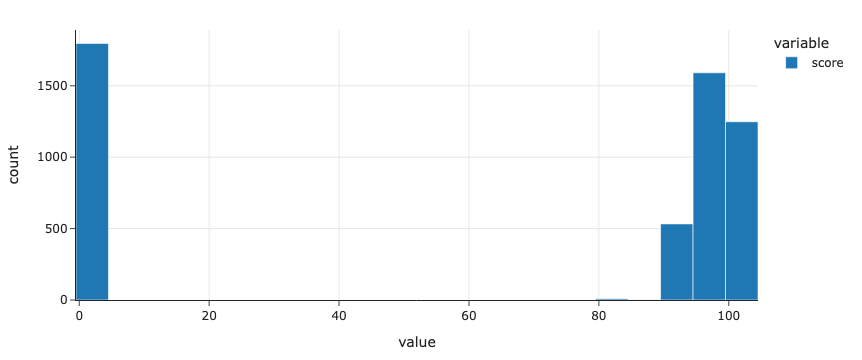

In [109]:
fig = px.histogram(insp['score'])
fig

How about the distribution of average inspection `'score'` per `'grade'`?

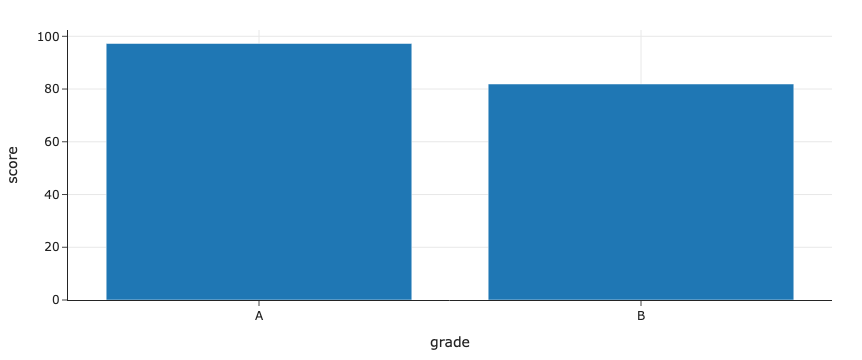

In [110]:
scores = (
    insp[['grade', 'score']]
    .dropna()
    .groupby('grade')
    .mean()
    .reset_index()
)
# x= and y= are columns of scores. Convenient!
px.bar(scores, x='grade', y='score')

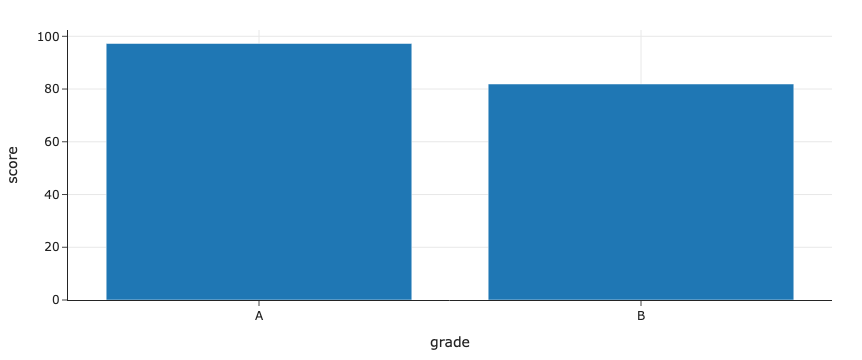

In [111]:
# Same as the above!
scores.plot(kind='bar', x='grade', y='score')

## Exploratory data analysis and feature types

### The data science lifecycle, revisited

<center>
    <img src="imgs/ds-lifecycle.svg" width=50%>
</center>

We're at the stage of **understanding the data**.

### Exploratory data analysis (EDA)

- Historically, data analysis was dominated by formal statistics, including tools like confidence intervals, hypothesis tests, and statistical modeling.

- In 1977, John Tukey [defined](https://search.worldcat.org/title/3058187) the term **exploratory data analysis**, which described a philosophy for proceeding about data analysis:

> Exploratory data analysis is actively incisive, rather than passively descriptive, with real emphasis on the discovery of the unexpected.

- Practically, EDA involves, among other things, computing summary statistics and drawing plots to understand the nature of the data at hand.

> The greatest gains from data come from surprises… The unexpected is best brought to our attention by **pictures**.

### Different feature types

<center><img src='imgs/data-types.png' width=90%></center>

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `types`
</div>
    
Determine the **feature type** of each of the following variables.
    
- `insp['score']`
- `insp['grade']`
- `viol['violation_accela']`
- `viol['major_violation']`
- `rest['business_id']`
- `rest['opened_date']`

</div>



In [42]:
# Your code goes here.

### Feature types vs. data types

- The data type `pandas` uses is not the same as the "data type" we talked about just now!
    - There's a difference between feature type and computational data type.

- Take care when the two don't match up very well!

In [43]:
# pandas stores these as ints, but they're actually nominal.
rest['business_id']

0      211898487641
1      211930769329
2      211909057778
           ...     
997    211899338714
998    211942150255
999    211925713322
Name: business_id, Length: 1000, dtype: int64

In [44]:
# pandas stores these as strings, but they're actually numeric.
rest['opened_date']

0      2002-05-05
1      2023-07-24
2      2019-01-22
          ...    
997    2002-05-05
998    2016-11-03
999    2022-11-03
Name: opened_date, Length: 1000, dtype: object

## Data cleaning

### Four pillars of data cleaning

When loading in a dataset, to clean the data – that is, to prepare it for further analysis – we will:

1. Perform **data quality checks**.

2. Identify and handle **missing values**.

3. Perform **transformations**, including converting time series data to **timestamps**.

4. Modify **structure** as necessary.

## Data cleaning: Data quality checks

### Data quality checks

We often start an analysis by checking the quality of the data.

- Scope: Do the data match your understanding of the population? 
- Measurements and values: Are the values reasonable?
- Relationships: Are related features in agreement?
- Analysis: Which features might be useful in a future analysis? 

### Scope

Do the data match your understanding of the population?

We were told that we're only looking at the 1000 restaurants closest to UCSD, so the restaurants in `rest` should agree with that.

In [45]:
rest.sample(5)

,business_id,name,business_type,address,...,lat,long,opened_date,distance
40,211903197364,HYATT REGENCY LA JOLLA - DRIFT,Satellite Food Service Operation,"3777 LA JOLLA VILLAGE DR, SAN DIEGO, CA 92122-...",...,32.87,-117.23,2020-09-09,0.82
116,211978008480,JOE AND THE JUICE,Restaurant Food Facility,"4305 LA JOLLA VILLAGE DR, SAN DIEGO, CA 92122",...,32.87,-117.21,2018-03-06,1.31
954,211899192225,SESSIONS ELEMENTARY,School Food Auxiliary Facility,"2150 BERYL ST, SAN DIEGO, CA 92109",...,32.81,-117.23,2002-05-05,4.87
785,211914874020,TONKATSU IZAKAYA EENAMI,Restaurant Food Facility,"4706 CLAIREMONT MESA BLVD, SAN DIEGO, CA 92117...",...,32.84,-117.19,2020-03-11,4.04
420,211916844973,CARGO CAFE,Single Operating Site,"6190 CORNERSTONE CT, SAN DIEGO, CA 92121-3766",...,32.90,-117.19,2017-12-29,2.93


### Measurements and values

Are the values reasonable?

Do the values in the `'grade'` column match what we'd expect grades to look like?

In [46]:
insp['grade'].value_counts()

grade
A    2978
B      11
Name: count, dtype: int64

What kinds of information does the `insp` DataFrame hold?

In [47]:
insp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5179 entries, 0 to 5178
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   custom_id       5179 non-null   object 
 1   business_id     5179 non-null   int64  
 2   inspection_id   5179 non-null   int64  
 3   description     0 non-null      float64
 4   type            5179 non-null   object 
 5   score           5179 non-null   int64  
 6   grade           2989 non-null   object 
 7   completed_date  5179 non-null   object 
 8   status          5179 non-null   object 
 9   link            5179 non-null   object 
 10  status_link     5179 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 445.2+ KB


What's going on in the `'address'` column of `rest`?

In [48]:
# Are there multiple restaurants with the same address?
rest['address'].value_counts()

address
5300 GRAND DEL MAR CT, SAN DIEGO, CA 92130       9
8657 VILLA LA JOLLA DR, LA JOLLA, CA 92037       8
4545 LA JOLLA VILLAGE DR, SAN DIEGO, CA 92122    8
                                                ..
3963 GOVERNOR DR, SAN DIEGO, CA 92122            1
4041 GOVERNOR DR, SAN DIEGO, CA 92122-2520       1
2672 DEL MAR HEIGHTS RD, DEL MAR, CA 92014       1
Name: count, Length: 863, dtype: int64

In [49]:
# Keeps all rows with duplicate addresses.
(
    rest
    .groupby('address')
    .filter(lambda df: df.shape[0] >= 2)
    .sort_values('address')
)

,business_id,name,business_type,address,...,lat,long,opened_date,distance
406,211899308875,NASEEMS BAKERY & KABOB,Restaurant Food Facility,"10066 PACIFIC HEIGHTS BLVD, SAN DIEGO, CA 92121",...,32.90,-117.19,2012-04-17,2.77
402,211898699154,HANAYA SUSHI CAFE,Restaurant Food Facility,"10066 PACIFIC HEIGHTS BLVD, SAN DIEGO, CA 92121",...,32.90,-117.19,2011-03-22,2.77
401,211899558107,ARMANDOS MEXICAN FOOD,Restaurant Food Facility,"10066 PACIFIC HEIGHTS BLVD, SAN DIEGO, CA 92121",...,32.90,-117.19,2005-06-28,2.77
...,...,...,...,...,...,...,...,...,...
575,211972411855,TARA HEATHER CAKE DESIGN,Caterer,"9932 MESA RIM RD, SUITE# A, SAN DIEGO, CA 9212...",...,32.90,-117.18,2014-04-24,3.51
344,211990537315,COMPASS GROUP FEDEX EXPRESS OLSON,Pre-Packaged Retail Market,"9999 OLSON DR, SAN DIEGO, CA 92121-2837",...,32.89,-117.20,2022-10-19,2.27
343,211976587262,CANTEEN - FED EX OLSON,Pre-Packaged Retail Market,"9999 OLSON DR, SAN DIEGO, CA 92121-2837",...,32.89,-117.20,2020-07-31,2.27


In [50]:
# Does the same thing as above!
(
    rest[rest.duplicated(subset=['address'], keep=False)]
    .sort_values('address')
)

,business_id,name,business_type,address,...,lat,long,opened_date,distance
406,211899308875,NASEEMS BAKERY & KABOB,Restaurant Food Facility,"10066 PACIFIC HEIGHTS BLVD, SAN DIEGO, CA 92121",...,32.90,-117.19,2012-04-17,2.77
402,211898699154,HANAYA SUSHI CAFE,Restaurant Food Facility,"10066 PACIFIC HEIGHTS BLVD, SAN DIEGO, CA 92121",...,32.90,-117.19,2011-03-22,2.77
401,211899558107,ARMANDOS MEXICAN FOOD,Restaurant Food Facility,"10066 PACIFIC HEIGHTS BLVD, SAN DIEGO, CA 92121",...,32.90,-117.19,2005-06-28,2.77
...,...,...,...,...,...,...,...,...,...
575,211972411855,TARA HEATHER CAKE DESIGN,Caterer,"9932 MESA RIM RD, SUITE# A, SAN DIEGO, CA 9212...",...,32.90,-117.18,2014-04-24,3.51
344,211990537315,COMPASS GROUP FEDEX EXPRESS OLSON,Pre-Packaged Retail Market,"9999 OLSON DR, SAN DIEGO, CA 92121-2837",...,32.89,-117.20,2022-10-19,2.27
343,211976587262,CANTEEN - FED EX OLSON,Pre-Packaged Retail Market,"9999 OLSON DR, SAN DIEGO, CA 92121-2837",...,32.89,-117.20,2020-07-31,2.27


### Relationships

Are related features in agreement?

Do the `'address'`es and `'zip'` codes in `rest` match?

In [51]:
rest[['address', 'zip']]

,address,zip
0,"3233 LA JOLLA VILLAGE DR, LA JOLLA, CA 92037",92037
1,"8950 VILLA LA JOLLA DR, SUITE# B123, LA JOLLA,...",92037-1704
2,"6902 LA JOLLA BLVD, LA JOLLA, CA 92037",92037
...,...,...
997,"1234 TOURMALINE ST, SAN DIEGO, CA 92109-1856",92109-1856
998,"12925 EL CAMINO REAL, SUITE# AA4, SAN DIEGO, C...",92130
999,"2672 DEL MAR HEIGHTS RD, DEL MAR, CA 92014",92014


What about the `'score'`s and `'grade'`s in `insp`?

In [52]:
insp[['score', 'grade']]

,score,grade
0,96,NaN
1,98,NaN
2,98,NaN
...,...,...
5176,0,NaN
5177,0,NaN
5178,90,A


### Analysis

Which features might be useful in a future analysis?

- We're most interested in:
    - These columns in the `rest` DataFrame: `'business_id'`, `'name'`, `'address'`, `'zip'`, and `'opened_date'`.
    - These columns in the `insp` DataFrame: `'business_id'`, `'inspection_id'`, `'score'`, `'grade'`, `'completed_date'`, and `'status'`.
    - These columns in the `viol` DataFrame: `'inspection_id'`, `'violation'`, `'major_violation'`, `'violation_text'`, and `'violation_accela'`.

- Also, let's rename a few columns to make them easier to work with.

### 💡 Pro-Tip: Using `pipe`

When we manipulate DataFrames, it's best to define individual functions for each step, then use the `pipe` **method** to chain them all together.

The `pipe` DataFrame method takes in a function, which itself takes in a DataFrame and returns a DataFrame.

- In practice, we would add functions one by one to the top of a notebook, then `pipe` them all.
- For today, will keep re-running `pipe` to show data cleaning process.

In [53]:
def subset_rest(rest):
    return rest[['business_id', 'name', 'address', 'zip', 'opened_date']]

rest = (
    pd.read_csv(rest_path)
    .pipe(subset_rest)
)
rest

,business_id,name,address,zip,opened_date
0,211898487641,MOBIL MART LA JOLLA VILLAGE,"3233 LA JOLLA VILLAGE DR, LA JOLLA, CA 92037",92037,2002-05-05
1,211930769329,CAFE 477,"8950 VILLA LA JOLLA DR, SUITE# B123, LA JOLLA,...",92037-1704,2023-07-24
2,211909057778,VALLEY FARM MARKET,"6902 LA JOLLA BLVD, LA JOLLA, CA 92037",92037,2019-01-22
...,...,...,...,...,...
997,211899338714,PACIFIC BEACH ELEMENTARY,"1234 TOURMALINE ST, SAN DIEGO, CA 92109-1856",92109-1856,2002-05-05
998,211942150255,POKEWAN DEL MAR,"12925 EL CAMINO REAL, SUITE# AA4, SAN DIEGO, C...",92130,2016-11-03
999,211925713322,SAFFRONO LOUNGE RESTAURANT,"2672 DEL MAR HEIGHTS RD, DEL MAR, CA 92014",92014,2022-11-03


In [54]:
# Same as the above – but the above makes it easier to chain more .pipe calls afterwards.
subset_rest(pd.read_csv(rest_path))

,business_id,name,address,zip,opened_date
0,211898487641,MOBIL MART LA JOLLA VILLAGE,"3233 LA JOLLA VILLAGE DR, LA JOLLA, CA 92037",92037,2002-05-05
1,211930769329,CAFE 477,"8950 VILLA LA JOLLA DR, SUITE# B123, LA JOLLA,...",92037-1704,2023-07-24
2,211909057778,VALLEY FARM MARKET,"6902 LA JOLLA BLVD, LA JOLLA, CA 92037",92037,2019-01-22
...,...,...,...,...,...
997,211899338714,PACIFIC BEACH ELEMENTARY,"1234 TOURMALINE ST, SAN DIEGO, CA 92109-1856",92109-1856,2002-05-05
998,211942150255,POKEWAN DEL MAR,"12925 EL CAMINO REAL, SUITE# AA4, SAN DIEGO, C...",92130,2016-11-03
999,211925713322,SAFFRONO LOUNGE RESTAURANT,"2672 DEL MAR HEIGHTS RD, DEL MAR, CA 92014",92014,2022-11-03


Let's use `pipe` to keep (and rename) the subset of the columns we care about in the other two DataFrames as well.

In [55]:
def subset_insp(insp):
    return (
        insp[['business_id', 'inspection_id', 'score', 'grade', 'completed_date', 'status']]
        .rename(columns={'completed_date': 'date'})
    )

insp = (
    pd.read_csv(insp_path)
    .pipe(subset_insp)
)

In [56]:
def subset_viol(viol):
    return (
        viol[['inspection_id', 'violation', 'major_violation', 'violation_accela']]
        .rename(columns={'violation': 'kind',
                         'major_violation': 'is_major',
                         'violation_accela': 'violation'})
    )

viol = (
    pd.read_csv(viol_path)
    .pipe(subset_viol)
)

### Combining the restaurant data

Let's join all three DataFrames together so that we have all the data in a single DataFrame.

In [57]:
def merge_all_restaurant_data():
    return (
        rest
        .merge(insp, on='business_id', how='left')
        .merge(viol, on='inspection_id', how='left')
    )

df = merge_all_restaurant_data()
df

,business_id,name,address,zip,...,status,kind,is_major,violation
0,211898487641,MOBIL MART LA JOLLA VILLAGE,"3233 LA JOLLA VILLAGE DR, LA JOLLA, CA 92037",92037,...,Complete,Hot and Cold Water,Y,21. Hot & cold water available
1,211898487641,MOBIL MART LA JOLLA VILLAGE,"3233 LA JOLLA VILLAGE DR, LA JOLLA, CA 92037",92037,...,Complete,Hot and Cold Water,N,21. Hot & cold water available
2,211898487641,MOBIL MART LA JOLLA VILLAGE,"3233 LA JOLLA VILLAGE DR, LA JOLLA, CA 92037",92037,...,Complete,Holding Temperatures,N,7. Proper hot & cold holding temperatures
...,...,...,...,...,...,...,...,...,...
8728,211925713322,SAFFRONO LOUNGE RESTAURANT,"2672 DEL MAR HEIGHTS RD, DEL MAR, CA 92014",92014,...,Complete,"Equipment and Utensil Storage, Use",N,"35. Equipment / Utensils -approved, installed,..."
8729,211925713322,SAFFRONO LOUNGE RESTAURANT,"2672 DEL MAR HEIGHTS RD, DEL MAR, CA 92014",92014,...,Complete,Toilet Facilities,N,"43. Toilet facilities -properly constructed, s..."
8730,211925713322,SAFFRONO LOUNGE RESTAURANT,"2672 DEL MAR HEIGHTS RD, DEL MAR, CA 92014",92014,...,Complete,"Floors, Walls, and Ceilings",N,"45. Floor, walls and ceilings - built, maintai..."


<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `lefts`
</div>
    
Why should the function above use two left joins? What would go wrong if we used other kinds of joins?



## Data cleaning: Missing values

### Missing values

Next, it's important to check for and handle missing values, as they can have a big effect on your analysis.

In [58]:
insp[['score', 'grade']]

,score,grade
0,96,NaN
1,98,NaN
2,98,NaN
...,...,...
5176,0,NaN
5177,0,NaN
5178,90,A


In [59]:
# The proportion of values in each column that are missing.
insp.isna().mean()

business_id      0.00
inspection_id    0.00
score            0.00
grade            0.42
date             0.00
status           0.00
dtype: float64

In [60]:
# Why are there null values here?
# insp['inspection_id'] and viol['inspection_id'] don't have any null values...
df[df['inspection_id'].isna()]

,business_id,name,address,zip,...,status,kind,is_major,violation
759,211941133403,TASTY CHAI,"8878 REGENTS RD 105, SAN DIEGO, CA 92122-5853",92122-5853,...,NaN,NaN,NaN,NaN
1498,211915545446,EMBASSY SUITES SAN DIEGO LA JOLLA,"4550 LA JOLLA VILLAGE DR, SAN DIEGO, CA 92122-...",92122-1248,...,NaN,NaN,NaN,NaN
1672,211937443689,SERVICENOW,"4770 EASTGATE MALL, SAN DIEGO, CA 92121-1970",92121-1970,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8094,211997340975,COOKIE SCOOP,"7759 GASTON DR, SAN DIEGO, CA 92126-3036",92126-3036,...,NaN,NaN,NaN,NaN
8450,211900595220,I LOVE BANANA BREAD CO,"4068 DALLES AVE, SAN DIEGO, CA 92117-5518",92117-5518,...,NaN,NaN,NaN,NaN
8545,211963768842,PETRA KITCHEN,"5252 BALBOA ARMS DR 175, SAN DIEGO, CA 92117-4949",92117-4949,...,NaN,NaN,NaN,NaN


There are many ways of handling missing values, which we'll cover in an entire lecture next week. But a good first step is to check how many there are!

## Data cleaning: Transformations and timestamps

### Transformations and timestamps

From last class:

> A transformation results from performing some operation on every element in a sequence, e.g. a Series.

It's often useful to look at ways of transforming your data to make it easier to work with.

- Type conversions (e.g. changing the string `"$2.99"` to the number `2.99`).

- Unit conversion (e.g. feet to meters).

- Extraction (Getting `'vermin'` out of `'Vermin Violation Recorded on 10/10/2023'`).

### Creating timestamps

Most commonly, we'll parse dates into `pd.Timestamp` objects.

In [61]:
# Look at the dtype!
insp['date']

0       2023-02-16
1       2022-01-03
2       2020-12-03
           ...    
5176    2023-03-06
5177    2022-12-09
5178    2022-11-30
Name: date, Length: 5179, dtype: object

In [62]:
# This magical string tells Python what format the date is in.
# For more info: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
date_format = '%Y-%m-%d'
pd.to_datetime(insp['date'], format=date_format)

0      2023-02-16
1      2022-01-03
2      2020-12-03
          ...    
5176   2023-03-06
5177   2022-12-09
5178   2022-11-30
Name: date, Length: 5179, dtype: datetime64[ns]

In [63]:
# Another advantage of defining functions is that we can reuse this function
# for the 'opened_date' column in `rest` if we wanted to.
def parse_dates(insp, col):
    date_format = '%Y-%m-%d'
    dates = pd.to_datetime(insp[col], format=date_format)
    return insp.assign(**{col: dates})

insp = (
    pd.read_csv(insp_path)
    .pipe(subset_insp)
    .pipe(parse_dates, 'date')
)

# We should also remake df, since it depends on insp.
# Note that the new insp is used to create df!
df = merge_all_restaurant_data()

In [64]:
# Look at the dtype now!
df['date']

0      2023-02-16
1      2022-01-03
2      2020-12-03
          ...    
8728   2022-11-30
8729   2022-11-30
8730   2022-11-30
Name: date, Length: 8731, dtype: datetime64[ns]

### Working with timestamps

- We often want to adjust granularity of timestamps to see overall trends, or seasonality.
- Use the `resample` method in `pandas` ([documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)).
    - Think of it like a version of `groupby`, but for timestamps.
    - For instance, `insp.resample('2W', on='date')` separates every two weeks of data into a different group.

In [67]:
insp.resample('2W', on='date')['score'].mean()

date
2020-01-05    42.67
2020-01-19    59.33
2020-02-02    56.34
              ...  
2023-09-24    66.60
2023-10-08    59.58
2023-10-22    66.81
Freq: 2W-SUN, Name: score, Length: 100, dtype: float64

In [68]:
# Where are those numbers coming from?
insp[
    (insp['date'] >= pd.Timestamp('2020-01-05')) &
    (insp['date'] < pd.Timestamp('2020-01-19'))
]['score']

10        0
11       92
12        0
       ... 
4709      0
4988    100
5107     96
Name: score, Length: 86, dtype: int64

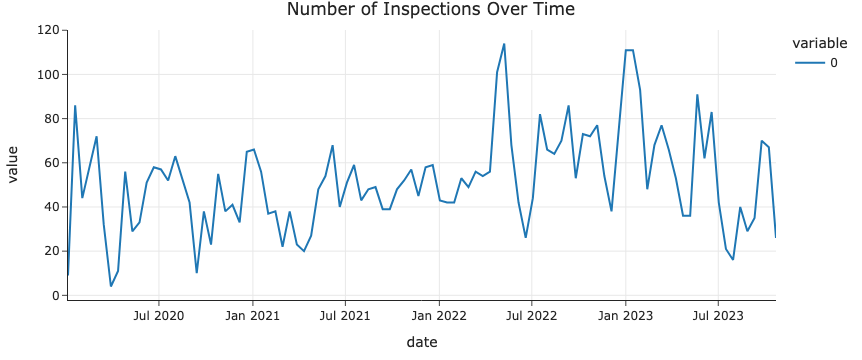

In [69]:
(insp.resample('2W', on='date')
 .size()
 .plot(title='Number of Inspections Over Time')
)

### The `.dt` accessor

Like with Series of strings, `pandas` has a `.dt` accessor for properties of timestamps ([documentation](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dt-accessors)).

In [70]:
insp['date']

0      2023-02-16
1      2022-01-03
2      2020-12-03
          ...    
5176   2023-03-06
5177   2022-12-09
5178   2022-11-30
Name: date, Length: 5179, dtype: datetime64[ns]

In [71]:
insp['date'].dt.day

0       16
1        3
2        3
        ..
5176     6
5177     9
5178    30
Name: date, Length: 5179, dtype: int32

In [72]:
insp['date'].dt.dayofweek

0       3
1       0
2       3
       ..
5176    0
5177    4
5178    2
Name: date, Length: 5179, dtype: int32

In [73]:
dow_counts = insp['date'].dt.dayofweek.value_counts()
fig = px.bar(dow_counts)
fig.update_xaxes(tickvals=np.arange(7), ticktext=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

## Data cleaning: Modifying structure

### Reshaping DataFrames

We often **reshape** the DataFrame's structure to make it more convenient for analysis. For example, we can:

- Simplify structure by removing columns or taking a set of rows for a particular period of time or geographic area.
    - We already did this!

- Adjust granularity by aggregating rows together.
    - To do this, use `groupby` (or `resample`, if working with timestamps).

- Reshape structure, most commonly by using the DataFrame `melt` method to un-pivot a dataframe.

### Using `melt`

- The `melt` method is common enough that we'll give it a special mention.
- We'll often encounter pivot tables (esp. from government data), which we call *wide* data.
- The methods we've introduced work better with *long-form* data, or *tidy* data.
- To go from wide to long, `melt`.

<center><img src='imgs/wide-vs-long.svg' width=40%></center>

### Example usage of `melt`

In [74]:
wide_example = pd.DataFrame({
    'Year': [2001, 2002],
    'Jan': [10, 130],
    'Feb': [20, 200],
    'Mar': [30, 340]
}).set_index('Year')
wide_example

,Jan,Feb,Mar
Year,,,
2001,10,20,30
2002,130,200,340


In [75]:
wide_example.melt(ignore_index=False)

,variable,value
Year,,
2001,Jan,10
2002,Jan,130
2001,Feb,20
2002,Feb,200
2001,Mar,30
2002,Mar,340


## Exploration

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `qs`
</div>
    
What questions do you want me to try and answer with the data? I'll start with a single pre-prepared question, and then answer student questions until we run out of time.

### Example question: Can we rank restaurants by their number of violations? How about separately for each zip code?

And why would we want to do that? 🤔

## Summary, next time

### Summary

- Data cleaning is a necessary starting step in data analysis. There are four pillars of data cleaning:
    - Quality checks.
    - Missing values.
    - Transformations and timestamps.
    - Modifying structure.
- Approach EDA with an open mind, and draw lots of visualizations.

### Next time

Hypothesis and permutation testing. Some of this will be DSC 10 review, but we'll also push further! 